
# Slim simulations



Load global analysis variables:

In [1]:
%run standard.py

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Sanity check of simulated autosomal diversity

Load simulation of autosome to check that diversity match expected diversity using the Pool-Nielsen coputation above.

In [9]:
dir_path = ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep/0/0/'
for path in dir_path.iterdir():
    if path.name.endswith('0_0_0.hdf'):
        df = pd.read_hdf(path)
        print(path.name, df.dist.mean())

standard_100_11300_A_nosweep_0_0_0.hdf 0.0006706096711202471


Looks ok.

## Facet plotting function

In [10]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
    plt.ylim((0, 1.1))
    plt.fill_between(x, 0, y, color='black', alpha=0.01)
    plt.axhline(y=0.29, linestyle='dashed')

## Load summary data for sweeps called on X chromosome simulations

In [11]:
prop_swept_data_auto = pd.read_hdf(str(ag.steps_dir / 'slim' / f'slim_summary.hdf')).loc[lambda df: df.chrom == 'A']
prop_swept_data_auto['prop_swept'] = prop_swept_data_auto.nr_swept / prop_swept_data_auto.total
prop_swept_data_auto['x_auto_ratio'] = prop_swept_data_auto['size_reduction'] * 3 / 4
prop_swept_data_auto.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_rate_per_gen,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio
0,0,100000,0,140,truncated,A,0.64,1.160000e-08,0,nosweep,0.0,2,29,0.0,0.48
1,100000,200000,0,140,truncated,A,0.64,1.160000e-08,0,nosweep,0.0,2,29,0.0,0.48
2,200000,300000,0,140,truncated,A,0.64,1.160000e-08,0,nosweep,0.0,2,29,0.0,0.48
3,300000,400000,0,140,truncated,A,0.64,1.160000e-08,0,nosweep,0.0,2,29,0.0,0.48
4,400000,500000,0,140,truncated,A,0.64,1.160000e-08,0,nosweep,0.0,2,29,0.0,0.48


In [12]:
plot_df = prop_swept_data_auto.loc[(prop_swept_data_auto.sweep_type == 'nosweep') & \
                                   (prop_swept_data_auto.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b0990cf4158> (for post_execute):


KeyboardInterrupt: 

## Load summary data for sweeps called on X chromosome simulations

In [ ]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf')).loc[lambda df: df.chrom == 'X']
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data['x_auto_ratio'] = prop_swept_data['size_reduction'] * 3 / 4
prop_swept_data.head()

## Neutral simulations

Standard demography:

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

Truncated demography:

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
                              (prop_swept_data.x_auto_ratio == 0.48)] 

with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=1)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") 

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated') & \
                              (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
                              (prop_swept_data.x_auto_ratio == 0.48)] 

with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=1)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") 

Load 90% ECH regions

In [ ]:
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
extended_peak_regions_90['chrom'] = 'chrX'

### Plots to make for real data and simulations

- Proportion of ECH in each individual
- Number of peaks that each individual is part of (accounting for whole chrX vs. 10Mb)
- Length distribution of ECHs
- Proportion of individuals with ECH (where ECHs ca called)

### Distribution of ECH peak heights and proportion of ECH across simulations

In [ ]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

Proportion of ECH across simulations:

In [ ]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

Bootstrap batches of 15 simulations to reproduce ~150Mb X chromosome to get 95% percentile:

In [ ]:
def bootstrap(df):
    return pd.Series([df.iloc[np.random.randint(len(df), size=15)].prop_swept.mean() for _ in range(10000)])

df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).apply(bootstrap).reset_index()
df = df.melt(id_vars=['rec_rate_per_gen', 'x_auto_ratio'])

In [ ]:
from scipy import stats


In [ ]:
df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).value.agg(mean_prop_swept=np.mean, 
                                                           quantile_5=lambda sr: np.quantile(sr, q=0.05),
                                                           quantile_95=lambda sr: np.quantile(sr, q=0.95),
                                                           prob=lambda sr: 1-stats.percentileofscore(sr, 0.14)/100
                                                          )

This is what compared to the 14% ECH in the actual data.

Distribution of peak prop_swept in simulations compared to our observations:

In [ ]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

In [ ]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True, legend_out=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

In [83]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated')]

Proportion of ECH across simulations:

In [84]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.055467
                  0.66            0.005682
1.160000e-08      0.48            0.004986
                  0.66            0.000154
Name: prop_swept, dtype: float64

This is what compared to the 14% ECH in the actual data. Given that only a part of the chromosme is as extreme as our regions, the expected prop_swept is between 1% and 5%:

Distribution of peak prop_swept in simulations compared to our observations:

In [85]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.458992
                  0.66            0.369048
1.160000e-08      0.48            0.374436
                  0.66            0.307143
Name: prop_swept, dtype: float64

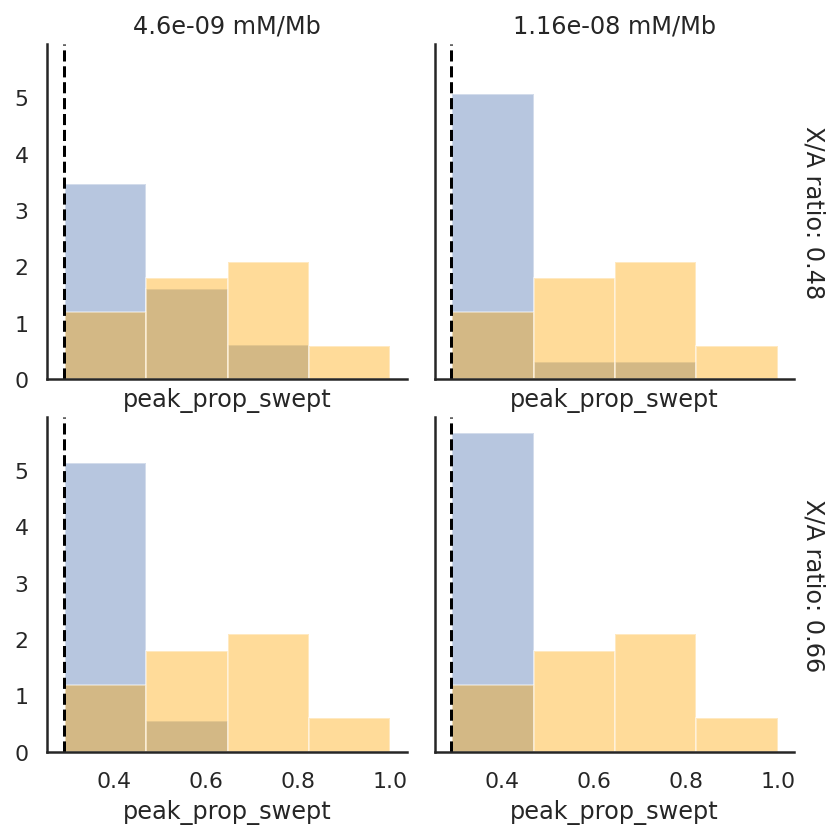

In [86]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

## Complete sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

## Partial sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

-----

In [ ]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('standard_40_4650')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [ ]:
prop_swept_data.simulation.unique()

In [ ]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['standard_55_4650_X_nosweep_98275',
                                                                          'standard_40_4650_X_nosweep_98275',
                                                                          'standard_48_4650_X_nosweep_98275',
                                                                          'standard_66_4650_X_nosweep_98275'])],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     height=4, aspect=0.5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



## TMRCA computations

In [ ]:
# from math import exp

# def lamb(i):
#     # lamb(i) rate of coalescence from i-1 to i
#     i += 1
#     return i*(i-1)/2

# samples = 5 # total samples
# setsize = 3 # size of clade (we want to see at least one such clade coalesce before time t)
# t = 1

# for n in range(setsize, samples+1):
#     # loop from setsize to samples (3 to 5):
#     p = 0
#     for i in range(1, n):
#         # loop from 1 to n-1:
#         p += np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j]) \
#         * exp(-lamb(n)*t) \
#         * (lamb(i)/(lamb(i)-lamb(n))) \
#         * (-exp(-(lamb(i)-lamb(n))*t) + 1)
#     # combinatorial expression:
#     p *= scipy.misc.comb(n, setsize) / scipy.misc.comb(samples, setsize)
# p
    


In [ ]:
# def lamb(x):
#     x += 1
#     return x*(x-1)/2


# N = 3000
# n = 42
# t = 1

# prob = 0
# for i in range(1, n):
#     prob += (1 - math.exp(-lamb(i)*t)) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j])
# prob * scipy.misc.comb(140, 42)

In [ ]:
#scipy.misc.comb(140, 42)

In [ ]:
#1- math.exp(-lamb(1))

In [ ]:
# def lamb(x):
#     return x*(x-1)/2

# t = 10
# n = 20

# prob = 0
# for i in range(1, n+1):
# #     print([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
#     prob += lamb(i) * math.exp(-lamb(i)*t) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
# prob #* scipy.misc.comb(n, i)

In [ ]:
#lamb(3)

In [ ]:
# import scipy

# def coal_n_to_l(n, l, t):
#     """Prob of reducing n lineages to l in time t"""
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     return scipy.linalg.expm(Q*t)[0][-1]

# def clade_prob(n, l, t, i):
#     """Prob of one among l lineages being ancestor to i among n"""
# #     if i == 1 or l == 1:
# #         return 1
# #     else:
#     return scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)
        
# n = 5
# t = 36
# pop_size = 300
# i = 2

# total_prop = 0
# for l in range(1, n):
#     total_prop += coal_n_to_l(n, l, t) * clade_prob(n, l, t, i)
# total_prop

In [ ]:
# n = 5
# t = 360
# pop_size = 30

# i = 2

# #l = 3

# total_prop = 0

# for l in [3]:#range(1, n):
    
#     # probability of having l out of n left at time t
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     prop_coalescences_n_to_l = scipy.linalg.expm(Q*t)[0][-1]
#     prop_coalescences_n_to_l

    
#     if i == 1 or l == 1:
#         prop_ancestor_to_i = 1 # CHECK THAT THIS IS OK
#     else:
#         prop_ancestor_to_i = scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)

#     assert prop_ancestor_to_i <= 1, prop_ancestor_to_i

#     prob = prop_coalescences_n_to_l * prop_ancestor_to_i

#     print(prop_coalescences_n_to_l, prop_ancestor_to_i)

#     total_prop += prob
# total_prop